In [108]:
import os                          
import glob                        
import time                       
import numpy as np                 
import pandas as pd             
import matplotlib.pyplot as plt  
import seaborn as sns           
sns.set_theme()

# sklearn imports
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    HistGradientBoostingRegressor
)
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error
)
from sklearn.model_selection import (
    cross_val_score,
    TimeSeriesSplit,
    RandomizedSearchCV
)

import xgboost as xgb                       
from IPython.display import clear_output    

In [109]:
!pip install lmoments


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [110]:
df_states = pd.read_csv('archive-4/stations_info.csv')
df_states.drop(columns=['agency', 'station_location', 'start_month'], inplace=True)
df_states.head()

,file_name,state,city,start_month_num,start_year
0,AP001,Andhra Pradesh,Tirupati,7,2016
1,AP002,Andhra Pradesh,Vijayawada,5,2017
2,AP003,Andhra Pradesh,Visakhapatnam,7,2017
3,AP004,Andhra Pradesh,Rajamahendravaram,9,2017
4,AP005,Andhra Pradesh,Amaravati,11,2017


In [111]:
unique_states = df_states['state'].unique()
unique_states

array(['Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar',
       'Chhattisgarh', 'Chandigarh', 'Delhi', 'Gujarat',
       'Himachal Pradesh', 'Haryana', 'Jharkhand', 'Jammu and Kashmir',
       'Karnataka', 'Kerala', 'Maharashtra', 'Meghalaya', 'Manipur',
       'Madhya Pradesh', 'Mizoram', 'Nagaland', 'Odisha', 'Punjab',
       'Puducherry', 'Rajasthan', 'Sikkim', 'Telangana', 'Tamil Nadu',
       'Tripura', 'Uttarakhand', 'Uttar Pradesh', 'West Bengal'],
      dtype=object)

In [112]:
import pandas as pd
from pathlib import Path

def combine_state_df(state_name):

    state_code = df_states.loc[df_states['state'] == state_name, 'file_name'].iloc[0][:2]
    state_files = Path('archive-4/').glob(f'{state_code}*.csv')
    print(state_code)

    combined_df = [pd.read_csv(state_file).assign(city=df_states.loc[df_states['file_name'] == state_file.stem, 'city'].astype('string').values[0]) for state_file in state_files]
        
    return pd.concat(combined_df)


In [113]:
df = combine_state_df('Delhi')
df.info()

DL
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2796171 entries, 0 to 20841
Data columns (total 60 columns):
 #   Column               Dtype  
---  ------               -----  
 0   From Date            object 
 1   To Date              object 
 2   PM2.5 (ug/m3)        float64
 3   PM10 (ug/m3)         float64
 4   NO (ug/m3)           float64
 5   NO2 (ug/m3)          float64
 6   NOx (ppb)            float64
 7   NH3 (ug/m3)          float64
 8   SO2 (ug/m3)          float64
 9   CO (mg/m3)           float64
 10  Ozone (ug/m3)        float64
 11  Benzene (ug/m3)      float64
 12  Toluene (ug/m3)      float64
 13  Eth-Benzene (ug/m3)  float64
 14  MP-Xylene (ug/m3)    float64
 15  RH (%)               float64
 16  WS (m/s)             float64
 17  WD (degree)          float64
 18  BP (mmHg)            float64
 19  Xylene (ug/m3)       float64
 20  AT (degree C)        float64
 21  RF (mm)              float64
 22  city                 object 
 23  Temp (degree C)      float64
 2

In [114]:
def create_dt_index(dataframe):
    dataframe = dataframe.drop(columns='To Date')
    dataframe['From Date'] = pd.to_datetime(dataframe['From Date'])
    dataframe = dataframe.rename(columns={'From Date': 'datetime'})
    return dataframe.set_index('datetime')

In [115]:
df = create_dt_index(df)
df.head(2)

,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3),...,O Xylene (ug/m3),CH4 (ug/m3),NMHC (ug/m3),SPM (ug/m3),THC (ug/m3),Gust (km/hr),MP-Xylene (),Eth-Benzene (),Xylene (),CH4 ()
datetime,,,,,,,,,,,,,,,,,,,,,
2020-11-13 14:00:00,142.70,390.00,0.57,17.92,18.48,48.87,2.78,0.83,39.24,2.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-13 15:00:00,130.43,326.85,1.58,17.61,19.19,56.64,2.69,0.71,30.93,2.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
def plot_similar_feature(dataframe, feature_groups, columns=2):
    rows = int((len(feature_groups)/columns)//1)
    fig, axes = plt.subplots(rows, columns, figsize=(13, 4*rows))
    fig.tight_layout(pad=3.0)
    
    row_num = 0
    col_num = 0
    for pos, group in enumerate(feature_groups):
        if pos % columns == 0 and pos != 0:
            row_num += 1
            col_num = 0
            
        for feature in feature_groups[group]:
            df_feature = dataframe[dataframe[feature].notnull()][feature]
            df_feature = df_feature.groupby([df_feature.index.year]).mean(numeric_only=True)
            sns.lineplot(data=df_feature, label=feature, ax=axes[row_num, col_num])
        axes[row_num, col_num].set_title(group)
        axes[row_num, col_num].set(xlabel=None)
        col_num += 1

    plt.plot()

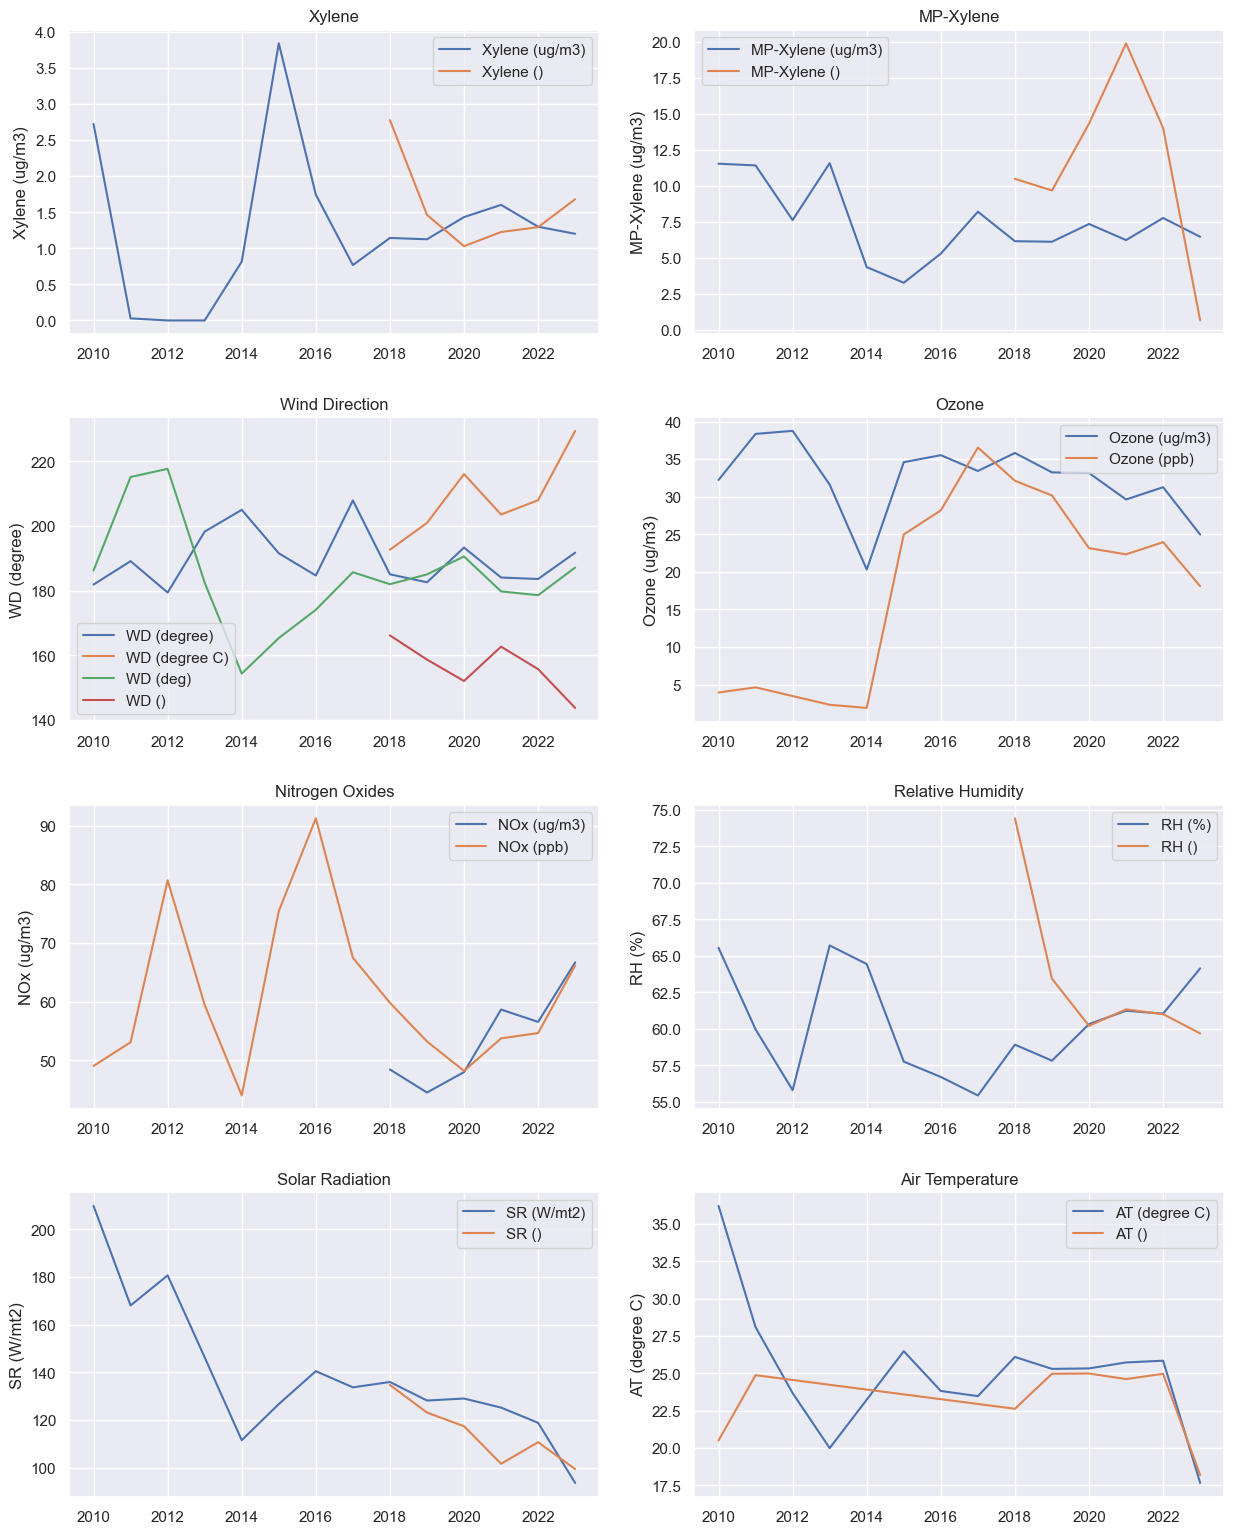

In [117]:
groups = {
    'Xylene':            ['Xylene (ug/m3)', 'Xylene ()'],
    "MP-Xylene":         ['MP-Xylene (ug/m3)', 'MP-Xylene ()'],
    'Wind Direction':    ["WD (degree)", "WD (degree C)", "WD (deg)", "WD ()"],
    'Ozone':             ['Ozone (ug/m3)', 'Ozone (ppb)'],
    'Nitrogen Oxides':   ['NOx (ug/m3)', 'NOx (ppb)'],
    'Relative Humidity': ['RH (%)', 'RH ()'],
    'Solar Radiation':   ['SR (W/mt2)', 'SR ()'],
    'Air Temperature':   ['AT (degree C)', 'AT ()']
}

plot_similar_feature(df, groups, columns=2)

In [118]:
feature_groups = {
    "Xylene (ug/m3)":    ["Xylene ()"],
    "MP-Xylene (ug/m3)": ["MP-Xylene ()"],
    "Benzene (ug/m3)":   ["Benzene ()"],
    "Toluene (ug/m3)":   ["Toluene ()"],
    "SO2 (ug/m3)":       ["SO2 ()"],
    "NOx (ug/m3)":       ["NOx (ppb)"],
    "Ozone (ug/m3)":     ["Ozone (ppb)"],
    "AT (degree C)":     ["AT ()"],
    "WD (degree)":       ["WD (degree C)", "WD (deg)", "WD ()"],
    "WS (m/s)":          ["WS ()"]
}

In [119]:
def merge_columns(dataframe, columns):

    for column, cols_to_merge in columns.items():
        if column not in dataframe.columns and any(col in dataframe.columns for col in cols_to_merge):
            dataframe[column] = np.nan

        for col_name in cols_to_merge:
            if col_name in dataframe.columns:
                dataframe[column] = dataframe[column].fillna(dataframe[col_name])
                dataframe = dataframe.drop(columns=[col_name])
            
    return dataframe

In [120]:
df = merge_columns(df, feature_groups)

In [121]:
df.head(1)

,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3),Toluene (ug/m3),...,HCHO (ug/m3),Hg (ug/m3),O Xylene (ug/m3),CH4 (ug/m3),NMHC (ug/m3),SPM (ug/m3),THC (ug/m3),Gust (km/hr),Eth-Benzene (),CH4 ()
datetime,,,,,,,,,,,,,,,,,,,,,
2020-11-13 14:00:00,142.7,390.0,0.57,17.92,48.87,2.78,0.83,39.24,2.4,6.77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
df.isnull().sum().sort_values(ascending=False)

Gust (kl/h)            2796171
Variance (n)           2796171
Eth-Benzene ()         2796171
Gust (km/hr)           2796171
SPM (ug/m3)            2796171
NMHC (ug/m3)           2796171
Temp (ug/m3)           2796171
Gust (m/s)             2796171
CO2 (mg/m3)            2796171
Power (W)              2796171
CH4 ()                 2785343
HCHO (ug/m3)           2762343
Hg (ug/m3)             2761020
MH (m)                 2758723
BP ()                  2756663
RH ()                  2756449
SR ()                  2752904
CO (ng/m3)             2752432
CH4 (ug/m3)            2734776
THC (ug/m3)            2733520
CO (ug/m3)             2712197
O Xylene (ug/m3)       2611212
Eth-Benzene (ug/m3)    2568923
Xylene (ug/m3)         2518649
MP-Xylene (ug/m3)      2502198
VWS (m/s)              2370506
Temp (degree C)        2295873
RF (mm)                1899980
AT (degree C)          1602321
BP (mmHg)              1417134
NH3 (ug/m3)            1366814
Toluene (ug/m3)        1313863
Benzene 

In [123]:
df = df.dropna(how='all')
df = df.dropna(how='all', axis='columns')

In [124]:
def get_null_info(dataframe):
    null_counts = df.isnull().sum()
    total_counts = len(df)
    percent_missing = (null_counts / total_counts) * 100

    null_info = pd.DataFrame({'Null Count': null_counts,
                            'Percent Missing (%)': percent_missing.round(2)})

    return null_info.sort_values(by='Null Count', ascending=False)


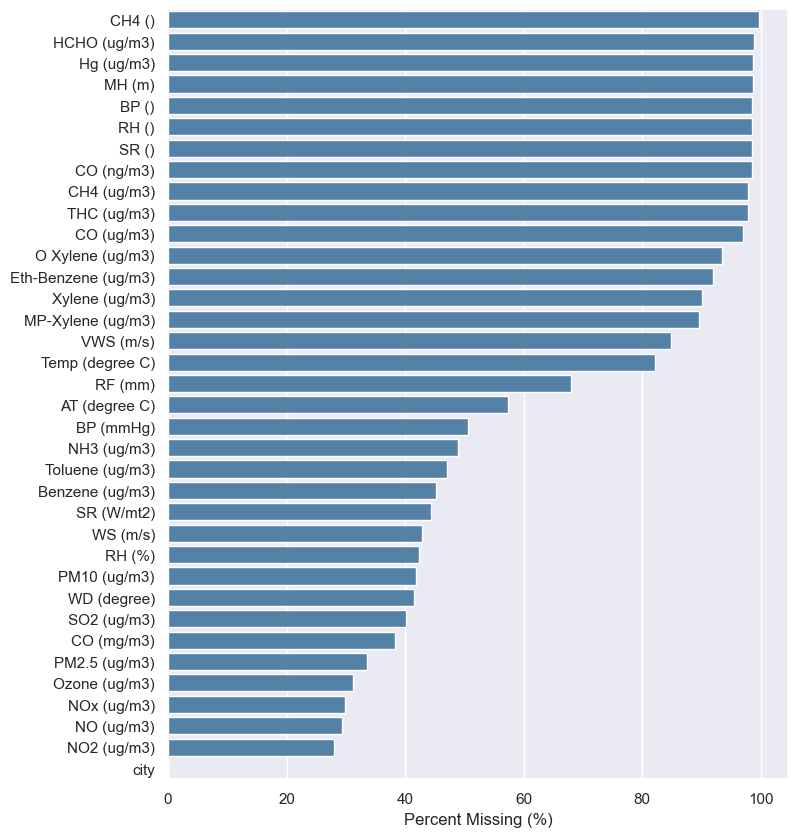

In [125]:
df_null_info = get_null_info(df)

plt.figure(figsize=(8, 10))
sns.barplot(data=df_null_info, x='Percent Missing (%)', y=df_null_info.index, orient='h', color='steelblue')
plt.show()

In [126]:
threshold = 0.6
df = df.dropna(thresh=df.shape[0]*threshold, axis=1)

In [127]:
df.head(2)

,PM2.5 (ug/m3),NO (ug/m3),NO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),city,NOx (ug/m3)
datetime,,,,,,,
2020-11-13 14:00:00,142.70,0.57,17.92,0.83,39.24,Delhi,18.48
2020-11-13 15:00:00,130.43,1.58,17.61,0.71,30.93,Delhi,19.19


In [128]:
get_null_info(df)

,Null Count,Percent Missing (%)
CO (mg/m3),1070972,38.30
PM2.5 (ug/m3),939895,33.61
Ozone (ug/m3),873898,31.25
NOx (ug/m3),833619,29.81
NO (ug/m3),821483,29.38
NO2 (ug/m3),783452,28.02
city,0,0.00


In [129]:
pollutants = {
    'Particulate Matter' : ['PM2.5 (ug/m3)', 'PM10 (ug/m3)'],

    'Nitrogen Compounds' : ['NOx (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'NH3 (ug/m3)'],

    'Hydrocarbons' : ['Benzene (ug/m3)', 'Eth-Benzene (ug/m3)', 'Xylene (ug/m3)', 'MP-Xylene (ug/m3)', 'O Xylene (ug/m3)', 'Toluene (ug/m3)'],

    'Carbon Monoxide': ['CO (mg/m3)'],

    'Sulfur Dioxide': ['SO2 (ug/m3)'],

    'Ozone Concentration' : ['Ozone (ug/m3)']
}

other_metrics = {
    'Solar Radiation' : ['SR (W/mt2)'],

    'Temperatures' : ['Temp (degree C)', 'AT (degree C)'],

    'Relative Humidity' : ['RH (%)'],

    'Rainfall' : ['RF (mm)'],

    'Barometric Pressure' : ['BP (mmHg)'],

    'Wind Direction' : ['WD (degree)'],

    'Wind Speed' : ['WS (m/s)']
}

In [130]:
slice_groups = {
    'Group by Day':   df.groupby(pd.Grouper(freq='1D')).mean(numeric_only=True),
    'Group by Month': df.groupby(pd.Grouper(freq='1M')).mean(numeric_only=True),
    'Group by Year':  df.groupby(pd.Grouper(freq='1Y')).mean(numeric_only=True)
}

In [180]:
def plot_features_by_group(features, slice_groups):    
    for feature in features:
        fig, ax = plt.subplots(1, 1, figsize=(12, 4))
        fig.suptitle(feature)
        
        labels = []
        for feature_group, feature_group_df in slice_groups.items():
            feature_slice = feature_group_df[feature_group_df.columns.intersection(pollutants[feature])]

            #if feature == "Nitrogen Compounds":
            #    data_slice = data_slice.drop(['NO (ug/m3)', 'NO2 (ug/m3)'], axis=1)
                
            feature_slice.plot(kind="line", ax=ax)
            
            for column in feature_slice.columns:
                labels.append(f'{column} [{feature_group}]')
        
        ax.set(xlabel=None)
        ax.legend(labels)
        plt.plot()

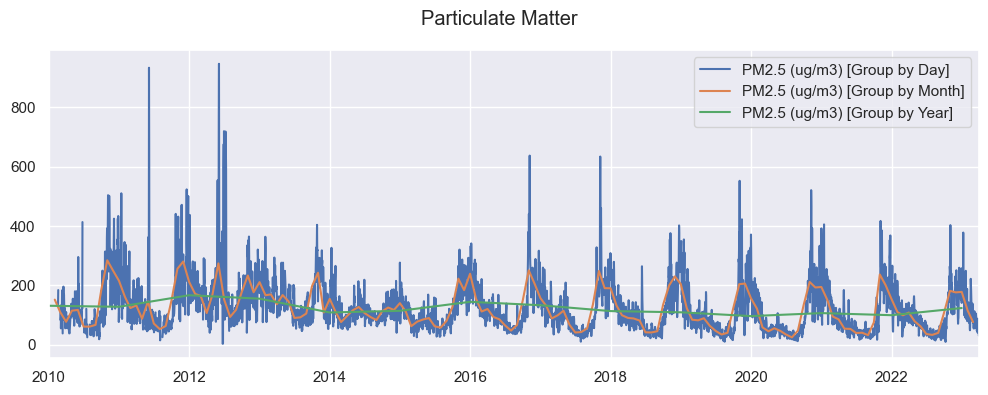

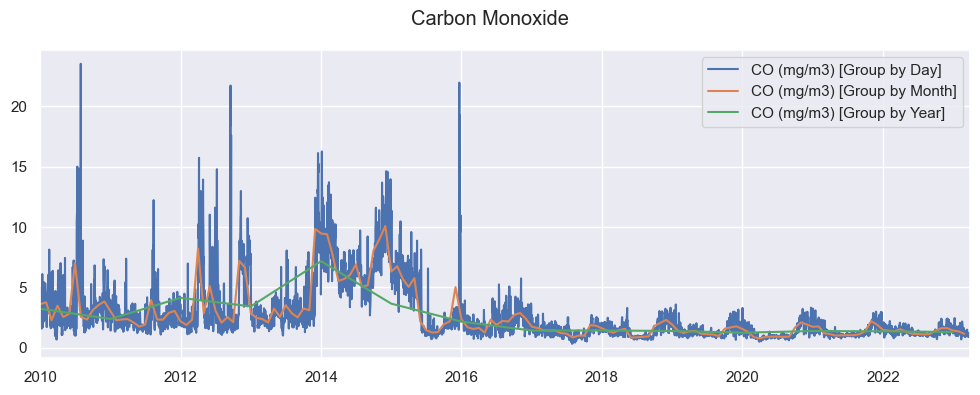

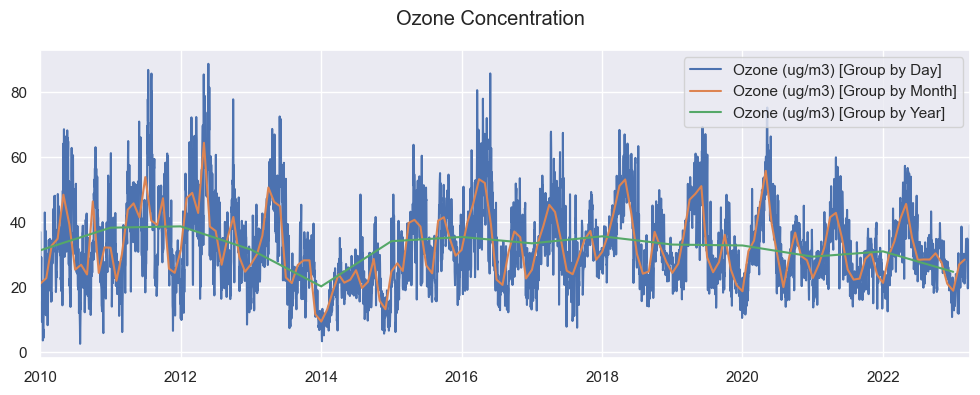

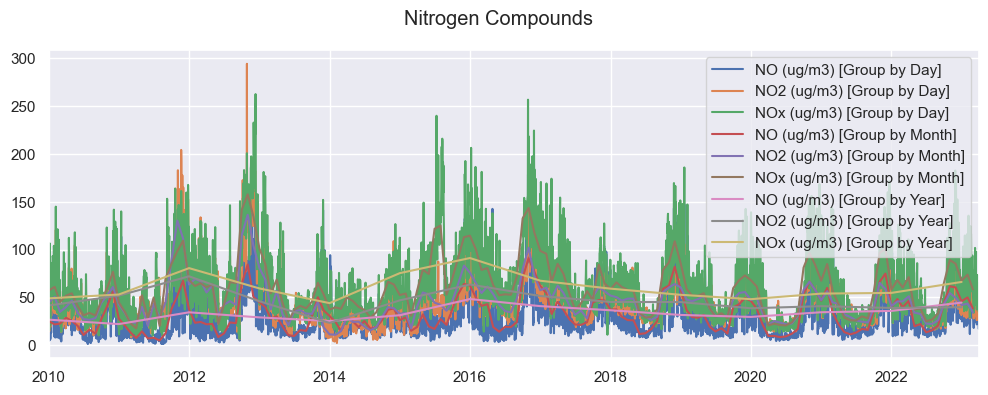

In [181]:
features_to_plot = ['Particulate Matter', 'Carbon Monoxide', 'Ozone Concentration', 'Nitrogen Compounds']
plot_features_by_group(features_to_plot, slice_groups)

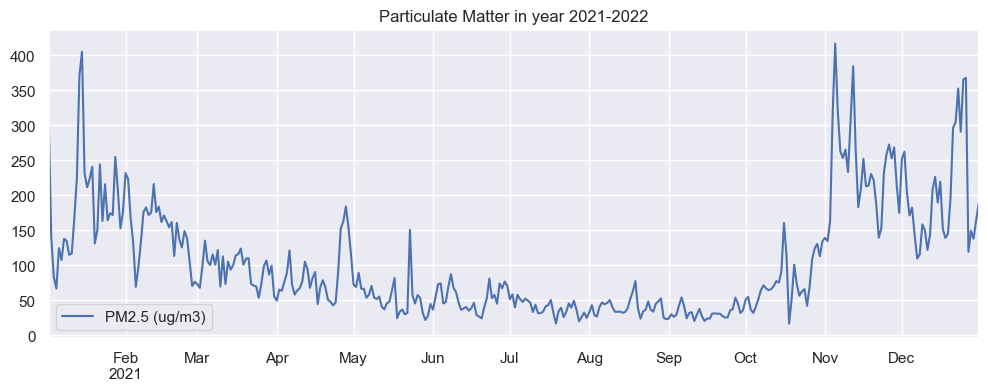

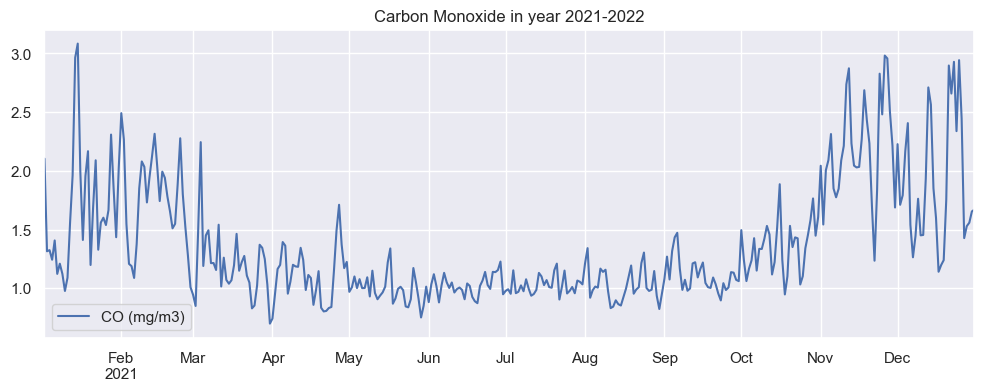

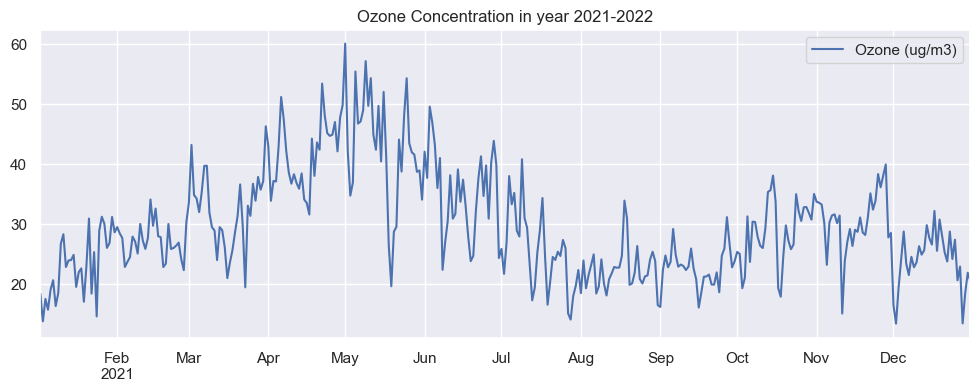

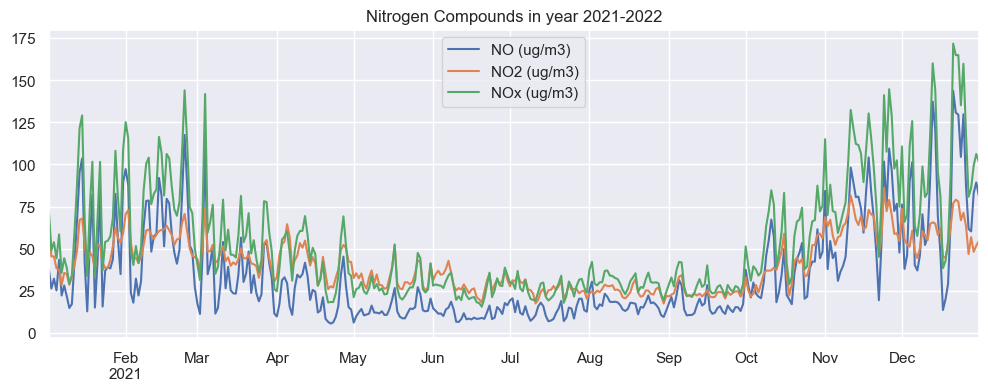

In [133]:
for feature in features_to_plot:
    data_slice = slice_groups['Group by Day'][slice_groups['Group by Day'].columns.intersection(pollutants[feature])]
    data_slice.query('datetime > 2021 and datetime < 2022').plot(title=f'{feature} in year 2021-2022', figsize=(12,4)).set(xlabel=None)

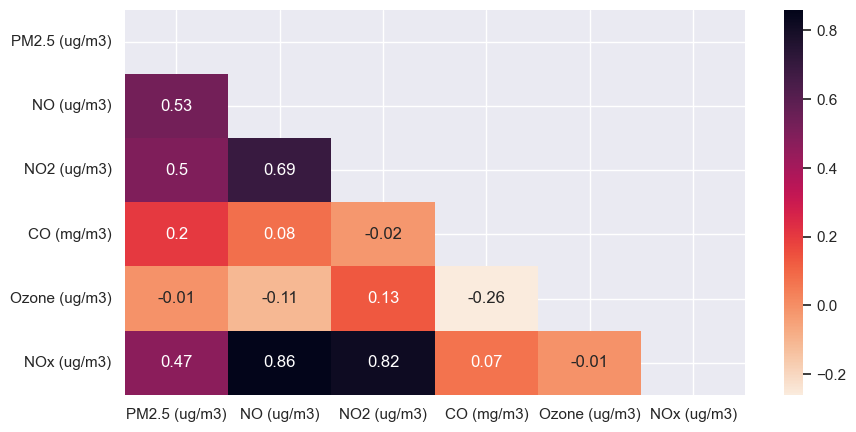

In [134]:
import numpy as np
corr = slice_groups['Group by Day'].corr(numeric_only=True).round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10,5))
sns.heatmap(data=corr, mask=mask, annot=True, cmap="rocket_r")
plt.show()

In [135]:
corr_target = abs(corr['PM2.5 (ug/m3)'])
relevant_features = corr_target[corr_target>0.4]
relevant_features.sort_values(ascending=False)

PM2.5 (ug/m3)    1.00
NO (ug/m3)       0.53
NO2 (ug/m3)      0.50
NOx (ug/m3)      0.47
Name: PM2.5 (ug/m3), dtype: float64

In [136]:
df = df.drop(['NO (ug/m3)', 'NO2 (ug/m3)'], axis=1)

In [137]:
df = df.resample('60min').mean(numeric_only=True)

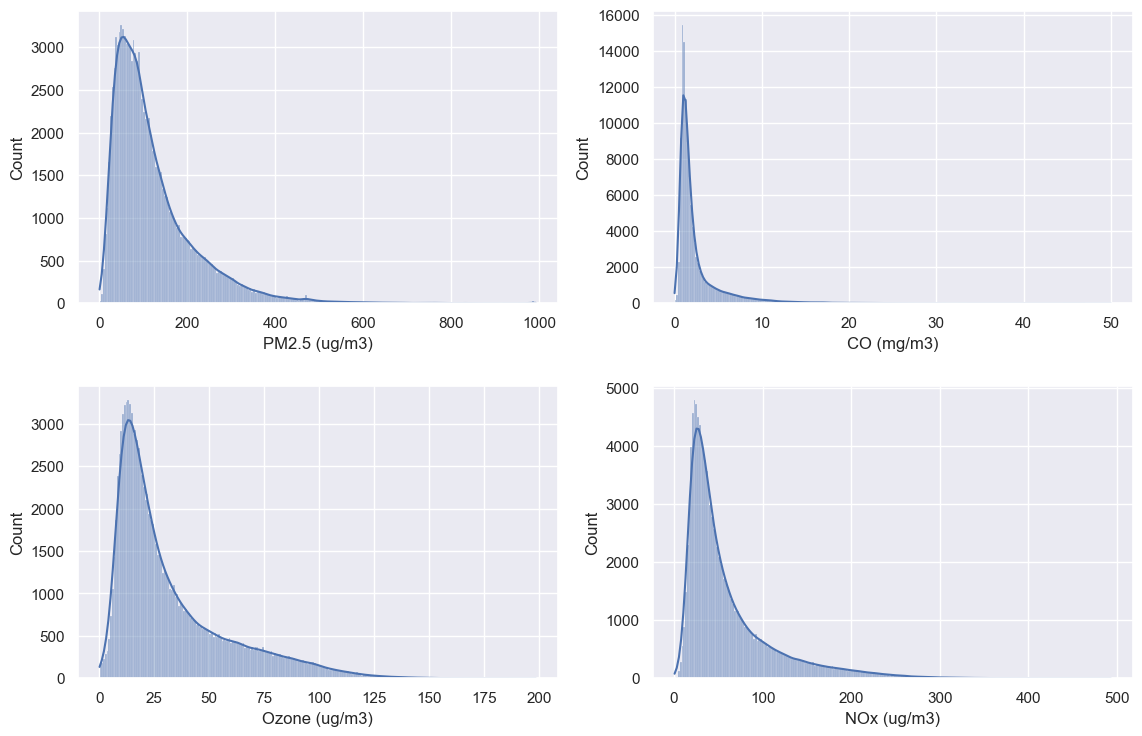

In [138]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.tight_layout(pad=3.0)

sns.histplot(data=df['PM2.5 (ug/m3)'], bins=250, kde=True, ax=axes[0,0])
sns.histplot(data=df['CO (mg/m3)'], bins=250, kde=True, ax=axes[0,1])
sns.histplot(data=df['Ozone (ug/m3)'], bins=250, kde=True, ax=axes[1,0])
sns.histplot(data=df['NOx (ug/m3)'], bins=250, kde=True, ax=axes[1,1])

plt.show()

<Axes: xlabel='datetime'>

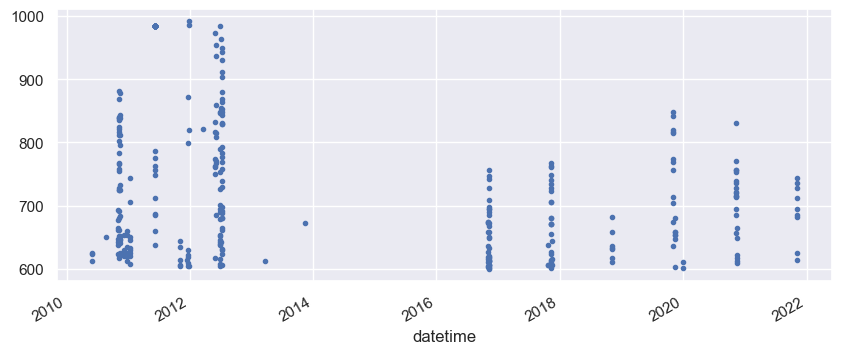

In [139]:
df.query('`PM2.5 (ug/m3)` > 600')['PM2.5 (ug/m3)'].plot(style='.', figsize=(10,4))

In [140]:
df['PM2.5 (ug/m3)'] = df['PM2.5 (ug/m3)'].mask(df['PM2.5 (ug/m3)'].gt(950))

<Axes: xlabel='datetime'>

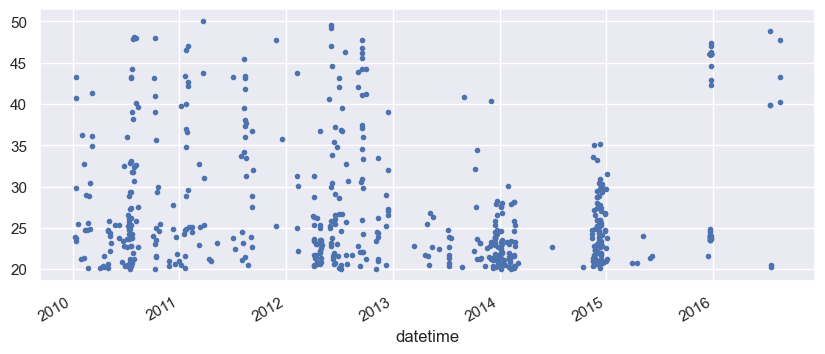

In [141]:
df.query('`CO (mg/m3)` > 20')['CO (mg/m3)'].plot(style='.', figsize=(10,4))

In [142]:
df['CO (mg/m3)'] = df['CO (mg/m3)'].mask(((df.index > '2015') & df['CO (mg/m3)'].gt(35)))

<Axes: xlabel='datetime'>

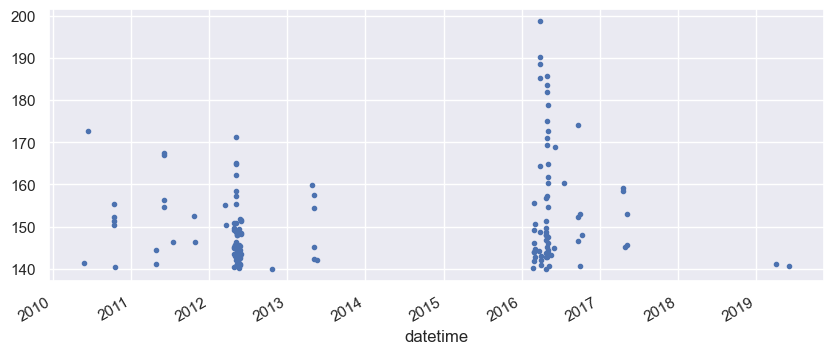

In [143]:
df.query('`Ozone (ug/m3)` > 140')['Ozone (ug/m3)'].plot(style='.', figsize=(10,4))

In [144]:
df['Ozone (ug/m3)'] = df['Ozone (ug/m3)'].mask(df['Ozone (ug/m3)'].gt(185))

<Axes: xlabel='datetime'>

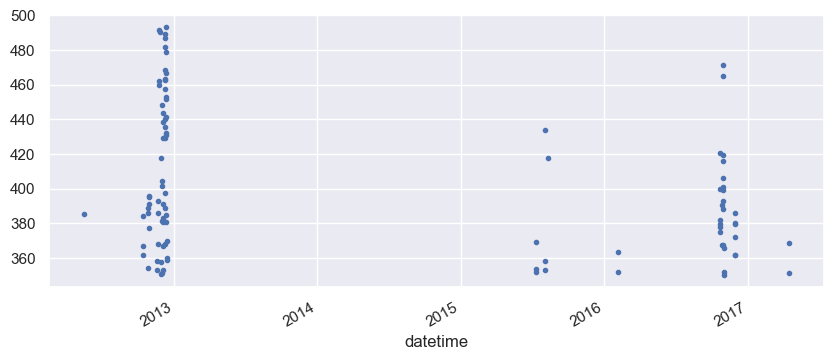

In [145]:
df.query('`NOx (ug/m3)` > 350')['NOx (ug/m3)'].plot(style='.', figsize=(10,4))

In [146]:
df['NOx (ug/m3)'] = df['NOx (ug/m3)'].mask((
    ((df.index < '2013') & (df['NOx (ug/m3)'].gt(380))) |
    ((df.index > '2015') & (df.index < '2016') & (df['NOx (ug/m3)'].gt(400))) |
    ((df.index > '2016') & (df['NOx (ug/m3)'].gt(450)))
))

In [147]:
get_null_info(df)

,Null Count,Percent Missing (%)
PM2.5 (ug/m3),3908,3.37
CO (mg/m3),2123,1.83
NOx (ug/m3),104,0.09
Ozone (ug/m3),67,0.06


In [148]:
df = df.interpolate(method='pad')
df = df.fillna(df.mean())
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116112 entries, 2010-01-01 00:00:00 to 2023-03-31 23:00:00
Freq: 60T
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   PM2.5 (ug/m3)  116112 non-null  float64
 1   CO (mg/m3)     116112 non-null  float64
 2   Ozone (ug/m3)  116112 non-null  float64
 3   NOx (ug/m3)    116112 non-null  float64
dtypes: float64(4)
memory usage: 4.4 MB


In [149]:
def create_features(df):
    df = df.copy()
    df['hour']       = df.index.hour
    df['dayofmonth'] = df.index.day
    df['dayofweek']  = df.index.dayofweek
    df['dayofyear']  = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week.astype("int64")
    df['month']      = df.index.month
    df['quarter']    = df.index.quarter
    df['year']       = df.index.year
    return df

In [150]:
date_features = ['hour', 'dayofmonth', 'dayofweek', 'dayofyear', 'weekofyear', 'month', 'quarter', 'year']
df_xgb = create_features(df)

In [151]:
def plot_by_datetime(metric, time_groups):
    for time_group in time_groups:
        fig, ax = plt.subplots(figsize=(12, 4))
        sns.boxplot(data=df_xgb, x=time_group, y=metric, palette="icefire", showfliers=False)
        ax.set_title(f'{metric} by {time_group}')
        ax.set(xlabel=time_group)
        plt.show()

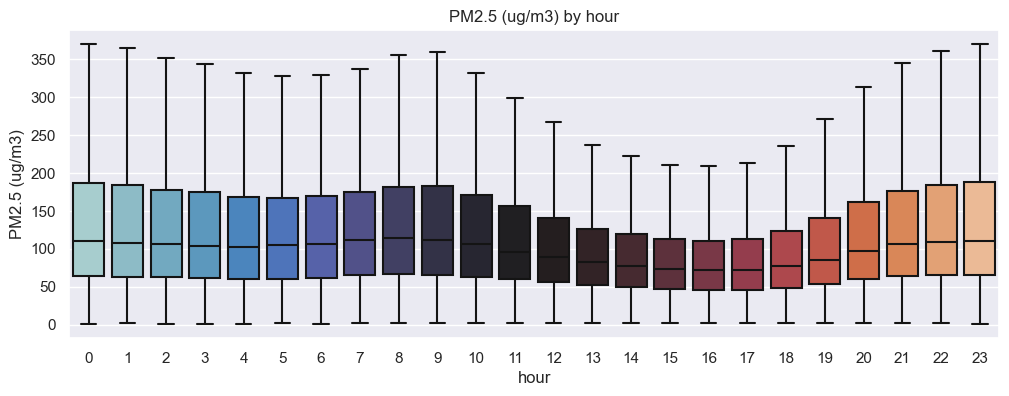

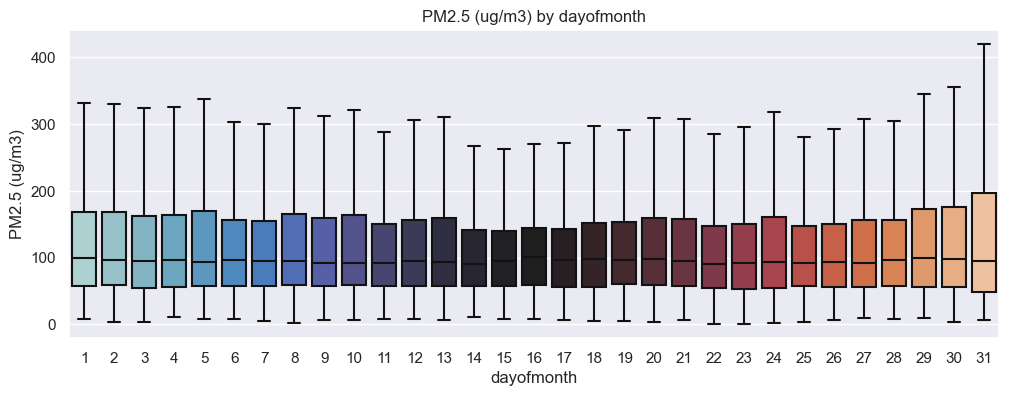

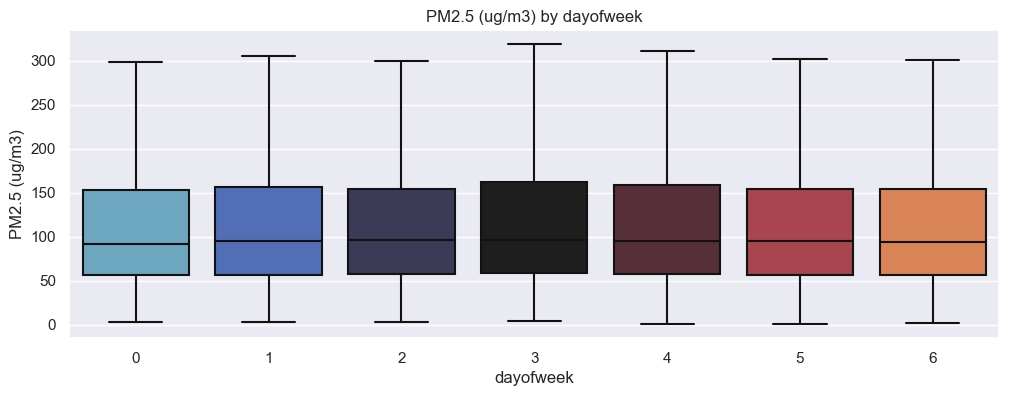

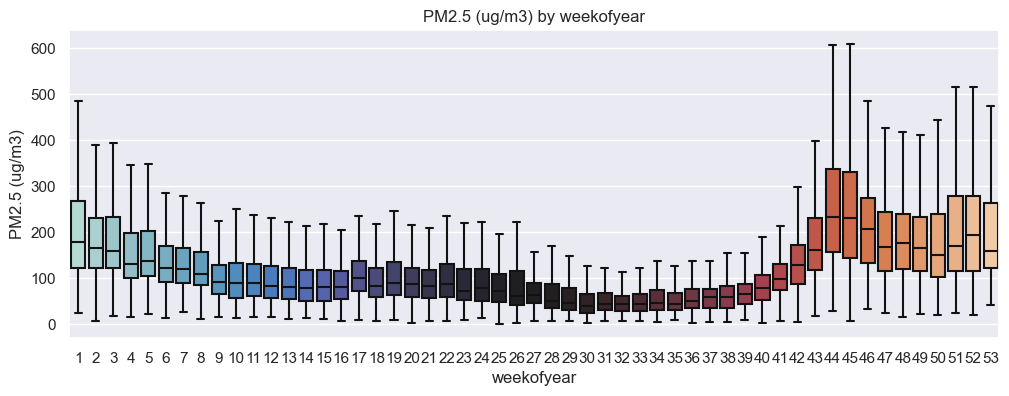

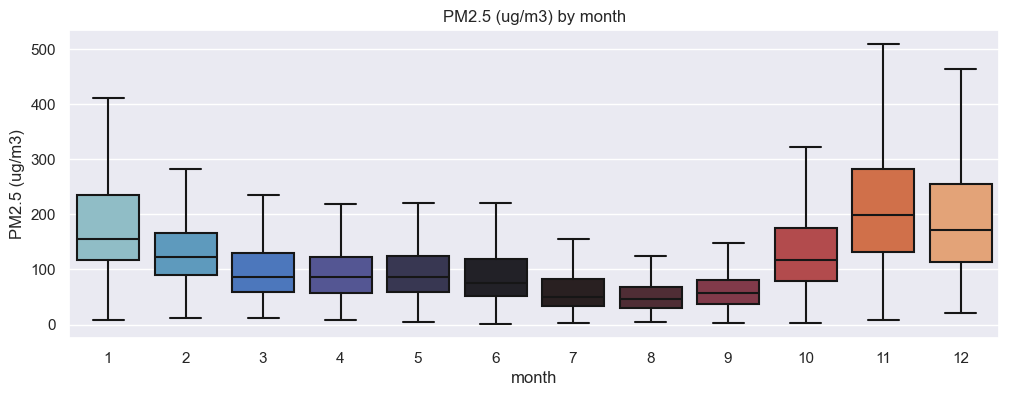

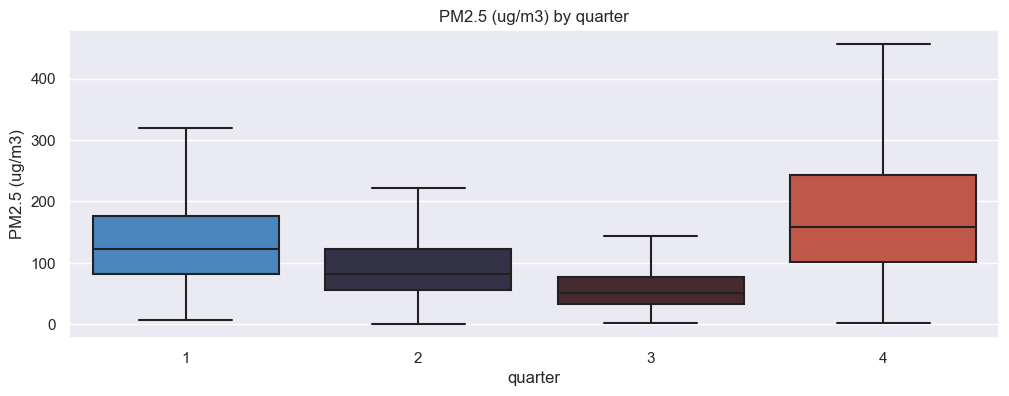

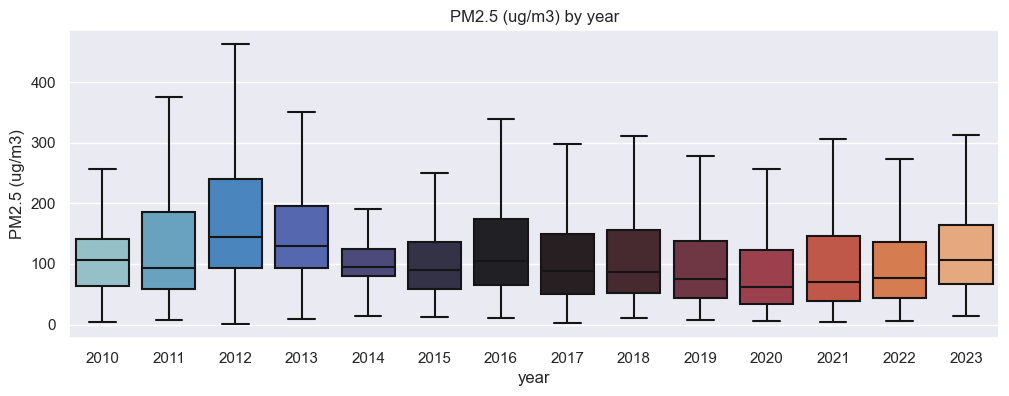

In [152]:
plot_by_datetime('PM2.5 (ug/m3)', date_features)

In [153]:
def create_lag_features(df):
    df = df.copy()
    df['lag_1Y'] = df['PM2.5 (ug/m3)'].shift(365*24)   # 1 year lag
    df['lag_2Y'] = df['PM2.5 (ug/m3)'].shift(730*24)   # 2 year lag
    return df

In [154]:
lag_features = ['lag_1Y', 'lag_2Y']
df_xgb = create_lag_features(df_xgb)
df_xgb.head()

,PM2.5 (ug/m3),CO (mg/m3),Ozone (ug/m3),NOx (ug/m3),hour,dayofmonth,dayofweek,dayofyear,weekofyear,month,quarter,year,lag_1Y,lag_2Y
datetime,,,,,,,,,,,,,,
2010-01-01 00:00:00,123.404029,2.340000,26.0650,73.7425,0,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 01:00:00,123.404029,2.327500,20.3425,36.0000,1,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 02:00:00,123.404029,2.177500,11.0650,27.1900,2,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 03:00:00,123.404029,1.992500,18.4625,21.1125,3,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 04:00:00,123.404029,2.096667,13.7500,23.1550,4,1,4,1,53,1,1,2010,NaN,NaN


In [155]:
def fill_lag_na(df, how):
    if how == 'zeros':
        return df.fillna(0)
    if how == 'drop':
        return df.dropna(how='any')

In [156]:
target = 'PM2.5 (ug/m3)'
predictors = date_features + lag_features

In [157]:
predictors

['hour',
 'dayofmonth',
 'dayofweek',
 'dayofyear',
 'weekofyear',
 'month',
 'quarter',
 'year',
 'lag_1Y',
 'lag_2Y']

In [158]:
df_xgb

,PM2.5 (ug/m3),CO (mg/m3),Ozone (ug/m3),NOx (ug/m3),hour,dayofmonth,dayofweek,dayofyear,weekofyear,month,quarter,year,lag_1Y,lag_2Y
datetime,,,,,,,,,,,,,,
2010-01-01 00:00:00,123.404029,2.340000,26.065000,73.742500,0,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 01:00:00,123.404029,2.327500,20.342500,36.000000,1,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 02:00:00,123.404029,2.177500,11.065000,27.190000,2,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 03:00:00,123.404029,1.992500,18.462500,21.112500,3,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 04:00:00,123.404029,2.096667,13.750000,23.155000,4,1,4,1,53,1,1,2010,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31 19:00:00,30.355000,1.087714,21.778947,35.103514,19,31,4,90,13,3,1,2023,89.304211,35.435294
2023-03-31 20:00:00,32.723421,1.181714,14.617895,39.896842,20,31,4,90,13,3,1,2023,128.842432,41.377059
2023-03-31 21:00:00,44.731081,1.188235,15.136757,40.194324,21,31,4,90,13,3,1,2023,152.542895,39.174242


In [159]:
def create_train_test_sets(dataframe, split, replace_na=False, method='none'):

    dataframe = dataframe.copy()
    
    if replace_na:
        dataframe = replace_lag_na(dataframe, how=method)
        
    train_set, test_set = np.split(dataframe, [int(len(df) * split)])
    return train_set[predictors], test_set[predictors], train_set[target], test_set[target]

In [160]:
X_train, X_test, y_train, y_test = create_train_test_sets(df_xgb, split=0.8, replace_na=True, method='drop')

In [161]:
X_train.size

928890

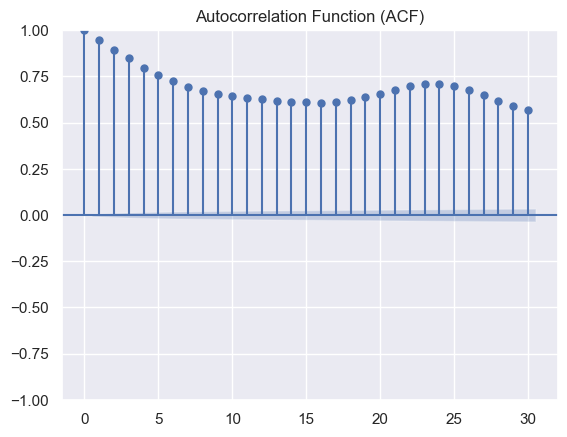

/Users/harshalgeete/miniconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



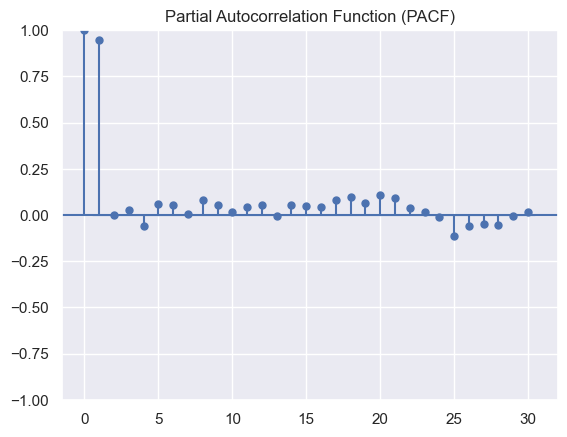

In [162]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

arima_df = X_train['lag_2Y'].values.squeeze()

plot_acf(arima_df, lags=30)
plt.title('Autocorrelation Function (ACF)')
plt.show()

plot_pacf(arima_df, lags=30)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [163]:
y_train

datetime
2012-01-01 00:00:00    296.970000
2012-01-01 01:00:00    379.845000
2012-01-01 02:00:00    398.910000
2012-01-01 03:00:00    381.935000
2012-01-01 04:00:00    480.950000
                          ...    
2022-08-06 04:00:00     49.553333
2022-08-06 05:00:00     51.960571
2022-08-06 06:00:00     56.522222
2022-08-06 07:00:00     60.582778
2022-08-06 08:00:00     55.718286
Freq: 60T, Name: PM2.5 (ug/m3), Length: 92889, dtype: float64

In [164]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_xgb['PM2.5 (ug/m3)'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -14.62629446685462
p-value: 3.814143071723405e-27
Critical Values: {'1%': -3.4304063546045076, '5%': -2.861564907890229, '10%': -2.5667832575917733}


ADF Statistics is negative, and the p-value is less than 0.05. This statistics allows us to reject the null-hypothesis stating that there exists some stationarity in the data. (d=0)

To check ‘p’, and ‘q’ parameters for the ARIMA model, ACF and PACF plots were generated. Both the ACF and PACF showed significant peaks at lag 1, therefore, the parameters passed to the ARIMA model were; ARIMA(p=1, d=0, q=1)

ARIMA Testing Root Mean Squared Error (RMSE): 89.964743092302


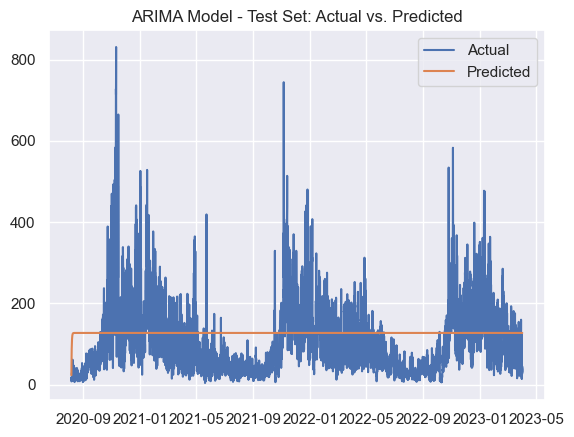

In [186]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

pm25_data = X_test['PM2.5 (ug/m3)']

#train, test = pm25_data.iloc[:train_size], pm25_data.iloc[int(len(pm25_data) * 0.8):]

model = ARIMA(train, order=(1, 0, 1))
model_fit = model.fit()

predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

arima_rmse = mean_squared_error(test, predictions, squared=False)
print(f'ARIMA Testing Root Mean Squared Error (RMSE): {arima_rmse}')

plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predictions, label='Predicted')
plt.legend()
plt.title('ARIMA Model - Test Set: Actual vs. Predicted')
plt.show()

ARIMA Training Root Mean Squared Error (RMSE): 32.964371560553964


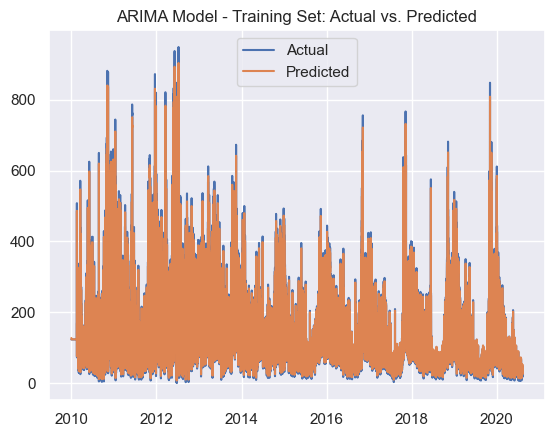

In [166]:
train_predictions = model_fit.predict(start=0, end=len(train) - 1, typ='levels')
train_rmse = mean_squared_error(train, train_predictions, squared=False)
print(f'ARIMA Training Root Mean Squared Error (RMSE): {train_rmse}')

plt.plot(train.index, train, label='Actual')
plt.plot(train.index, train_predictions, label='Predicted')
plt.legend()
plt.title('ARIMA Model - Training Set: Actual vs. Predicted')
plt.show()

In [167]:
from xgboost import XGBRegressor 

model = XGBRegressor()
model.fit(X_train, y_train)
predictions_test = model.predict(X_test)

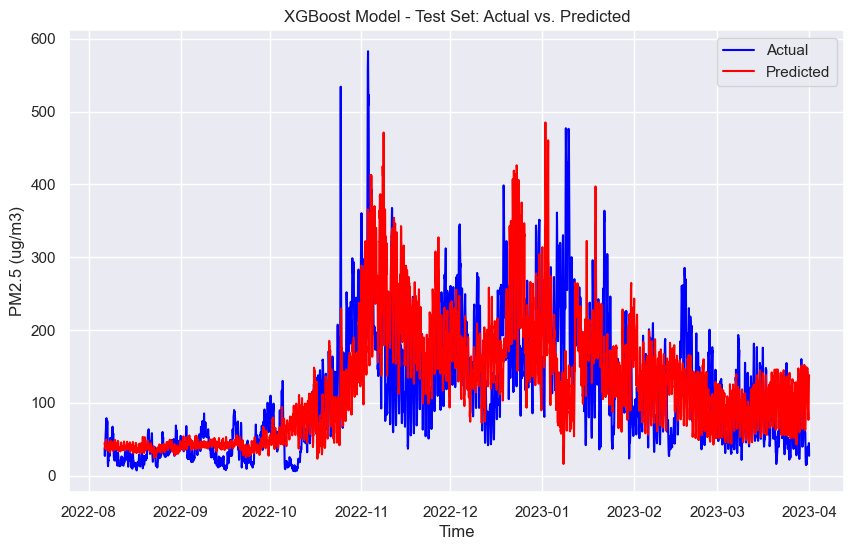

In [168]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, predictions_test, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('PM2.5 (ug/m3)')
plt.title('XGBoost Model - Test Set: Actual vs. Predicted')
plt.legend()
plt.show()

In [185]:
from sklearn.metrics import mean_squared_error
mse_xgb = np.sqrt(mean_squared_error(y_test, predictions_test))
print("Test RMSE for XGBoost:", mse_xgb)

Test RMSE for XGBoost: 67.3849455356703


In [169]:
predictions_train = model.predict(X_train)

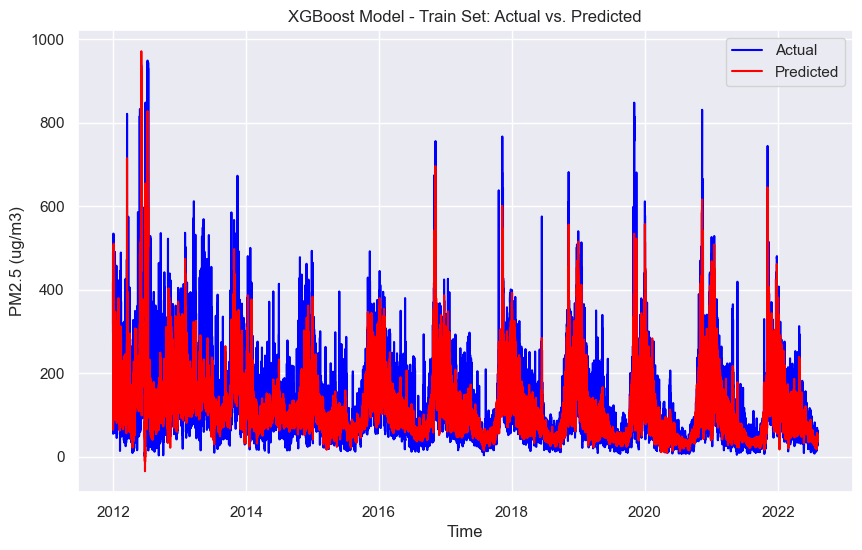

In [170]:
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label='Actual', color='blue')
plt.plot(y_train.index, predictions_train, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('PM2.5 (ug/m3)')
plt.title('XGBoost Model - Train Set: Actual vs. Predicted')
plt.legend()
plt.show()

In [184]:
from sklearn.metrics import mean_squared_error
mse_xgb = np.sqrt(mean_squared_error(y_train, predictions_train))
print("Train RMSE for XGBoost:", mse_xgb)

Train RMSE for XGBoost: 39.84878799233393


In [172]:
from sklearn.model_selection import (
    cross_val_score,
    TimeSeriesSplit,
    RandomizedSearchCV
)

N_JOBS = -1
RANDOM_STATE = 18
tscv = TimeSeriesSplit(n_splits=5) 

params = {'learning_rate': np.arange(0.01,1,0.01),
                'n_estimators': [20,50,100,250],
                'max_depth': [None,3,5],
                'eval_metric': ['rmse'],
                'early_stopping_rounds': [10],
                'n_jobs': [N_JOBS],
                'random_state': [RANDOM_STATE]}

rscv_model = RandomizedSearchCV(model, params,
                                        cv=tscv,
                                        scoring="neg_root_mean_squared_error",
                                        return_train_score=True,
                                        n_jobs=-1,
                                        n_iter=20,
                                        random_state=18)

In [173]:
rscv_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)    
model_xgb_rscv = rscv_model.best_estimator_
model_scores = round(-rscv_model.best_score_, 4)

print(model_xgb_rscv, model_scores)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.24000000000000002,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=-1,
             num_parallel_tree=None, random_state=18, ...) 69.2065


In [174]:
model_xgb_cv = model_xgb_rscv.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)
predictions_test_xgb_cv = model_xgb_cv.predict(X_test)

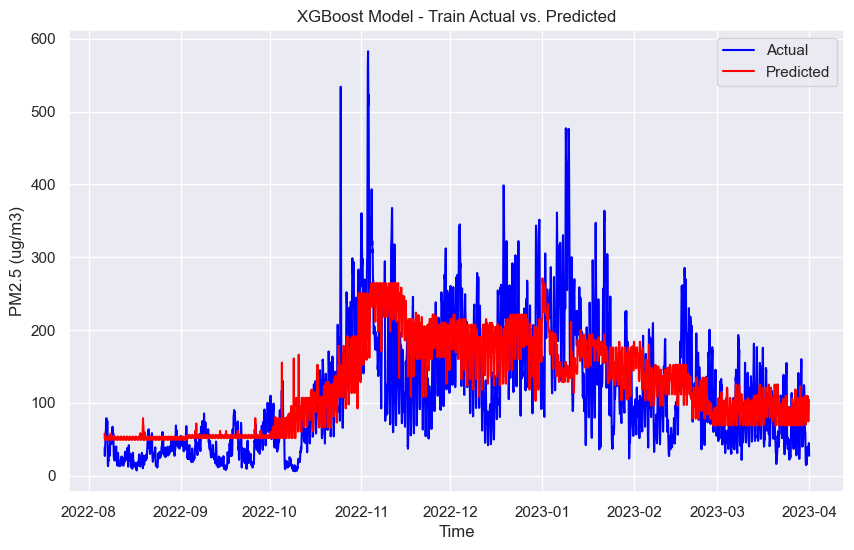

In [175]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, predictions_test_xgb_cv, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('PM2.5 (ug/m3)')
plt.title('XGBoost Model - Train Actual vs. Predicted')
plt.legend()
plt.show()

In [176]:
mse_xgb_cv = np.sqrt(mean_squared_error(y_test, predictions_test_xgb_cv))
print("RMSE after hyperparameter tuning:", mse_xgb_cv)

RMSE after hyperparameter tuning: 58.92586256584427


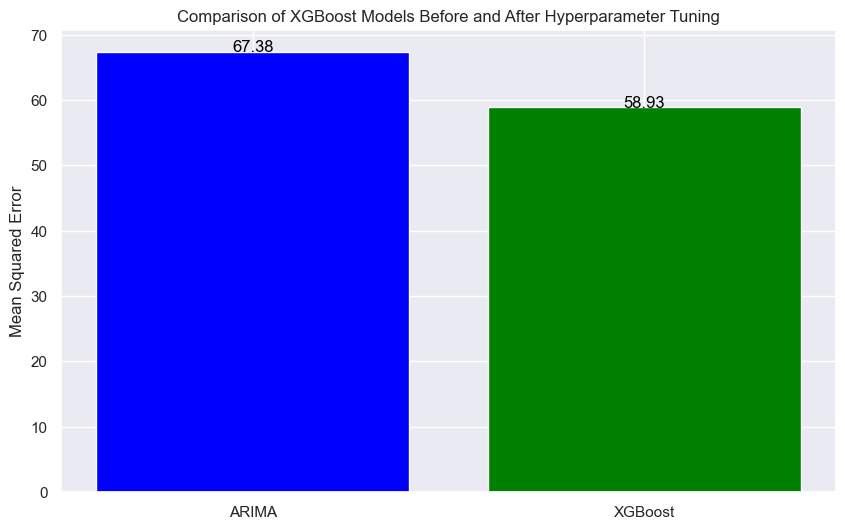

In [177]:
rmse_scores = [mse_xgb, mse_xgb_cv]

plt.figure(figsize=(10, 6))
plt.bar(['ARIMA', 'XGBoost'], rmse_scores, color=['blue', 'green'])

for x, y in zip(['ARIMA', 'XGBoost'], rmse_scores):
    plt.text(x, y + 0.01, f'{y:.2f}', ha='center', color='black')

plt.title('Comparison of XGBoost Models Before and After Hyperparameter Tuning')
plt.ylabel('Mean Squared Error')
plt.show()

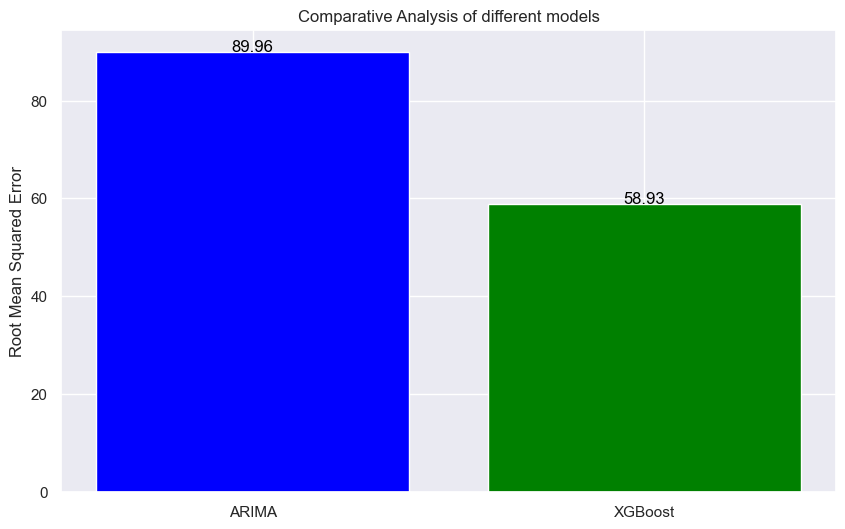

In [178]:
rmse_scores = [arima_rmse, mse_xgb_cv]

plt.figure(figsize=(10, 6))
plt.bar(['ARIMA', 'XGBoost'], rmse_scores, color=['blue', 'green'])

for x, y in zip(['ARIMA', 'XGBoost'], rmse_scores):
    plt.text(x, y + 0.01, f'{y:.2f}', ha='center', color='black')

plt.title('Comparative Analysis of different models')
plt.ylabel('Root Mean Squared Error')
plt.show()

In [179]:
import lmoments